In [ ]:
!pip install tensorflow

In [ ]:
pip install --upgrade tensorflow keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1


In [ ]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.17.0
3.5.0


In [ ]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

In [ ]:
# load dataset
dataset = pd.read_csv('BTC.csv')

In [ ]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# shape
dataset.shape

(20051, 9)

In [ ]:
# shape
dataset.shape

(20051, 9)

In [ ]:
# peek at data
set_option('display.width', 100)
dataset.tail(5)

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
20046,1513561980,2017-12-18 01:53:00,BTC/USD,18270.00,18322.56,18270.00,18299.96,11.643921,213083.297144
20047,1513561920,2017-12-18 01:52:00,BTC/USD,18374.17,18374.91,18228.57,18270.00,22.061486,403063.354153
20048,1513561860,2017-12-18 01:51:00,BTC/USD,18388.00,18388.65,18305.89,18374.20,10.192559,187280.115557
20049,1513561800,2017-12-18 01:50:00,BTC/USD,18388.64,18388.64,18356.44,18360.68,2.647256,48605.419560
20050,1513561740,2017-12-18 01:49:00,BTC/USD,18346.86,18398.80,NaN,NaN,NaN,NaN


In [ ]:
# describe data
pd.set_option('display.precision', 3)
dataset.describe()

,unix,open,high,low,close,Volume BTC,Volume USD
count,2.005e+04,20051.000,20051.000,20050.000,20050.000,20050.000,2.005e+04
mean,1.514e+09,15155.053,15182.461,15121.782,15154.565,14.406,2.153e+05
std,3.473e+05,1770.120,1766.508,1773.349,1770.050,21.690,3.153e+05
min,1.514e+09,11200.000,11250.120,11159.930,11200.000,0.000,0.000e+00
25%,1.514e+09,13907.975,13940.000,13876.632,13905.230,3.022,4.547e+04
50%,1.514e+09,14605.790,14638.300,14575.565,14601.025,7.325,1.111e+05
75%,1.514e+09,16292.720,16312.870,16256.573,16292.595,16.708,2.553e+05
max,1.515e+09,19215.860,19220.000,19200.000,19215.860,359.425,5.146e+06


In [ ]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = True


In [ ]:
dataset[dataset.columns.values] = dataset[dataset.columns.values].ffill()

In [ ]:
dataset=dataset.drop(columns=['unix'])

In [ ]:
# Initialize the `signals` DataFrame with the `signal` column
#datas['PriceMove'] = 0.0

# Create short simple moving average over the short window
dataset['short_mavg'] = dataset['close'].rolling(window=10, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
dataset['long_mavg'] = dataset['close'].rolling(window=60, min_periods=1, center=False).mean()

# Create signals
dataset['signal'] = np.where(dataset['short_mavg'] > dataset['long_mavg'], 1.0, 0.0)

In [ ]:
dataset.tail()

,date,symbol,open,high,low,close,Volume BTC,Volume USD
20046,2017-12-18 01:53:00,BTC/USD,18270.00,18322.56,18270.00,18299.96,11.644,213083.297
20047,2017-12-18 01:52:00,BTC/USD,18374.17,18374.91,18228.57,18270.00,22.061,403063.354
20048,2017-12-18 01:51:00,BTC/USD,18388.00,18388.65,18305.89,18374.20,10.193,187280.116
20049,2017-12-18 01:50:00,BTC/USD,18388.64,18388.64,18356.44,18360.68,2.647,48605.420
20050,2017-12-18 01:49:00,BTC/USD,18346.86,18398.80,18356.44,18360.68,2.647,48605.420


In [ ]:
#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA
dataset['EMA10'] = EMA(dataset, 10)
dataset['EMA30'] = EMA(dataset, 30)
dataset['EMA200'] = EMA(dataset, 200)
dataset.head()

#calculation of rate of change
def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))
    return ROC
dataset['ROC10'] = ROC(dataset['close'], 10)
dataset['ROC30'] = ROC(dataset['close'], 30)

#Calculation of price momentum
def MOM(df, n):
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))
    return MOM
dataset['MOM10'] = MOM(dataset['close'], 10)
dataset['MOM30'] = MOM(dataset['close'], 30)

#calculation of relative strength index
def RSI(series, period):
 delta = series.diff().dropna()
 u = delta * 0
 d = u.copy()
 u[delta > 0] = delta[delta > 0]
 d[delta < 0] = -delta[delta < 0]
 u[u.index[period-1]] = np.mean( u[:period] ) #first value is sum of avg gains
 u = u.drop(u.index[:(period-1)])
 d[d.index[period-1]] = np.mean( d[:period] ) #first value is sum of avg losses
 d = d.drop(d.index[:(period-1)])
 rs = u.ewm(com=period-1, adjust=False).mean() / \
 d.ewm(com=period-1, adjust=False).mean()
 return 100 - 100 / (1 + rs)
dataset['RSI10'] = RSI(dataset['close'], 10)
dataset['RSI30'] = RSI(dataset['close'], 30)
dataset['RSI200'] = RSI(dataset['close'], 200)

#calculation of stochastic osillator.

def STOK(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 return STOK

def STOD(close, low, high, n):
 STOK = ((close - low.rolling(n).min()) / (high.rolling(n).max() - low.rolling(n).min())) * 100
 STOD = STOK.rolling(3).mean()
 return STOD

dataset['%K10'] = STOK(dataset['close'], dataset['low'], dataset['high'], 10)
dataset['%D10'] = STOD(dataset['close'], dataset['low'], dataset['high'], 10)
dataset['%K30'] = STOK(dataset['close'], dataset['low'], dataset['high'], 30)
dataset['%D30'] = STOD(dataset['close'], dataset['low'], dataset['high'], 30)
dataset['%K200'] = STOK(dataset['close'], dataset['low'], dataset['high'], 200)
dataset['%D200'] = STOD(dataset['close'], dataset['low'], dataset['high'], 200)

In [ ]:
#Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA
dataset['MA21'] = MA(dataset, 10)
dataset['MA63'] = MA(dataset, 30)
dataset['MA252'] = MA(dataset, 200)
dataset.tail()

,date,symbol,open,high,low,close,Volume BTC,Volume USD,EMA10,EMA30,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
20046,2017-12-18 01:53:00,BTC/USD,18270.00,18322.56,18270.00,18299.96,11.644,213083.297,18366.657,18458.014,...,47.096,17.529,14.163,5.336,4.312,27.605,27.787,18371.436,18541.283,18550.306
20047,2017-12-18 01:52:00,BTC/USD,18374.17,18374.91,18228.57,18270.00,22.061,403063.354,18349.083,18445.884,...,46.859,17.490,19.993,5.579,6.171,24.374,27.105,18355.936,18527.307,18548.566
20048,2017-12-18 01:51:00,BTC/USD,18388.00,18388.65,18305.89,18374.20,10.193,187280.116,18353.650,18441.259,...,47.778,66.929,33.983,19.610,10.175,35.612,29.197,18347.185,18516.264,18547.287
20049,2017-12-18 01:50:00,BTC/USD,18388.64,18388.64,18356.44,18360.68,2.647,48605.420,18354.928,18436.060,...,47.670,81.389,55.269,17.938,14.375,34.154,31.380,18341.164,18504.955,18545.628
20050,2017-12-18 01:49:00,BTC/USD,18346.86,18398.80,18356.44,18360.68,2.647,48605.420,18355.974,18431.197,...,47.670,77.607,75.308,20.398,19.315,34.154,34.640,18338.361,18484.950,18543.947


In [ ]:
dataset.tail()

,date,symbol,open,high,low,close,Volume BTC,Volume USD,EMA10,EMA30,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
20046,2017-12-18 01:53:00,BTC/USD,18270.00,18322.56,18270.00,18299.96,11.644,213083.297,18366.657,18458.014,...,47.096,17.529,14.163,5.336,4.312,27.605,27.787,18371.436,18541.283,18550.306
20047,2017-12-18 01:52:00,BTC/USD,18374.17,18374.91,18228.57,18270.00,22.061,403063.354,18349.083,18445.884,...,46.859,17.490,19.993,5.579,6.171,24.374,27.105,18355.936,18527.307,18548.566
20048,2017-12-18 01:51:00,BTC/USD,18388.00,18388.65,18305.89,18374.20,10.193,187280.116,18353.650,18441.259,...,47.778,66.929,33.983,19.610,10.175,35.612,29.197,18347.185,18516.264,18547.287
20049,2017-12-18 01:50:00,BTC/USD,18388.64,18388.64,18356.44,18360.68,2.647,48605.420,18354.928,18436.060,...,47.670,81.389,55.269,17.938,14.375,34.154,31.380,18341.164,18504.955,18545.628
20050,2017-12-18 01:49:00,BTC/USD,18346.86,18398.80,18356.44,18360.68,2.647,48605.420,18355.974,18431.197,...,47.670,77.607,75.308,20.398,19.315,34.154,34.640,18338.361,18484.950,18543.947


In [ ]:
#excluding columns that are not needed for our prediction.

dataset=dataset.drop(['high','low','open', 'Volume USD','EMA10','EMA30'], axis=1)

In [ ]:
dataset = dataset.dropna(axis=0)

In [ ]:
dataset.tail()

,date,symbol,close,Volume BTC,EMA200,ROC10,ROC30,MOM10,MOM30,RSI10,...,RSI200,%K10,%D10,%K30,%D30,%K200,%D200,MA21,MA63,MA252
20046,2017-12-18 01:53:00,BTC/USD,18299.96,11.644,18547.348,-0.679,-2.083,-160.06,-375.25,30.172,...,47.096,17.529,14.163,5.336,4.312,27.605,27.787,18371.436,18541.283,18550.306
20047,2017-12-18 01:52:00,BTC/USD,18270.00,22.061,18544.588,-1.038,-2.328,-155.00,-419.26,27.542,...,46.859,17.490,19.993,5.579,6.171,24.374,27.105,18355.936,18527.307,18548.566
20048,2017-12-18 01:51:00,BTC/USD,18374.20,10.193,18542.893,-0.253,-1.742,-87.51,-331.29,45.800,...,47.778,66.929,33.983,19.610,10.175,35.612,29.197,18347.185,18516.264,18547.287
20049,2017-12-18 01:50:00,BTC/USD,18360.68,2.647,18541.080,-0.152,-3.165,-60.21,-339.29,44.194,...,47.670,81.389,55.269,17.938,14.375,34.154,31.380,18341.164,18504.955,18545.628
20050,2017-12-18 01:49:00,BTC/USD,18360.68,2.647,18539.285,-0.056,-1.287,-28.03,-600.15,44.194,...,47.670,77.607,75.308,20.398,19.315,34.154,34.640,18338.361,18484.950,18543.947


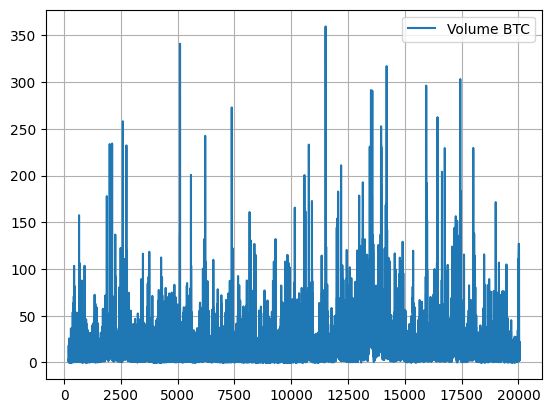

In [ ]:
dataset[['Volume BTC']].plot(grid=True)
plt.show()

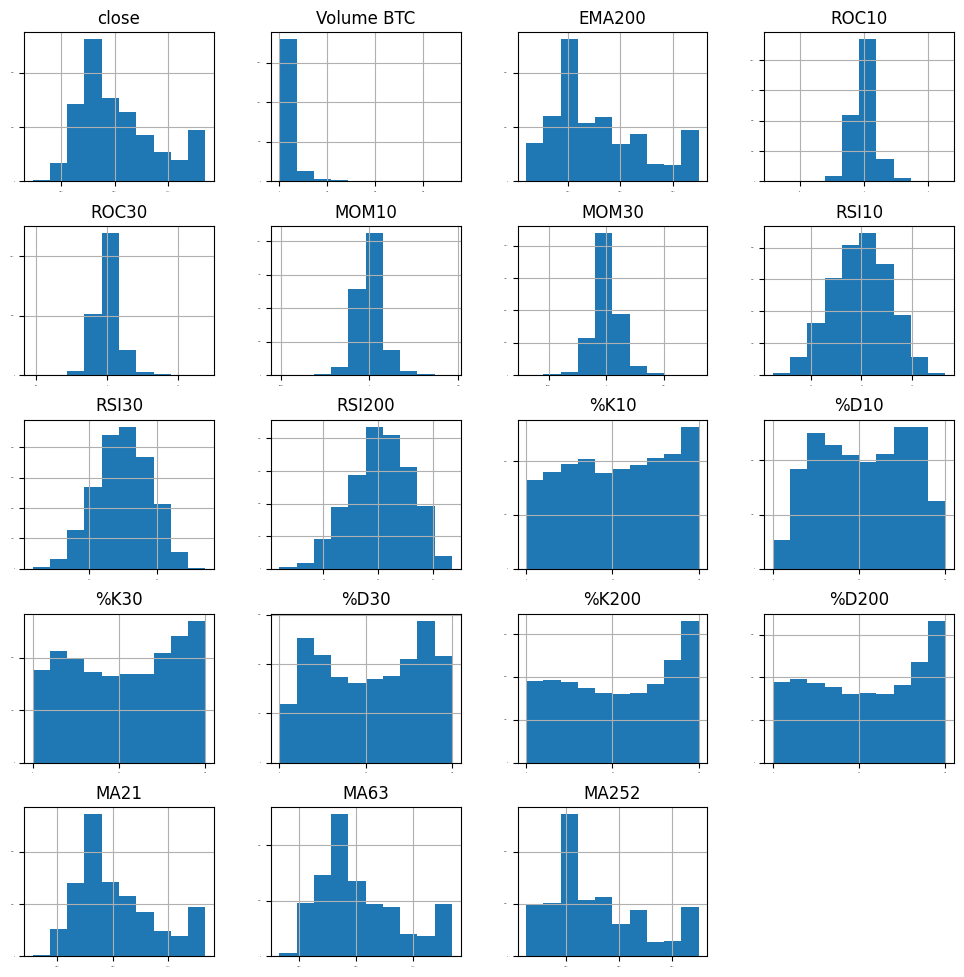

In [ ]:
# histograms
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

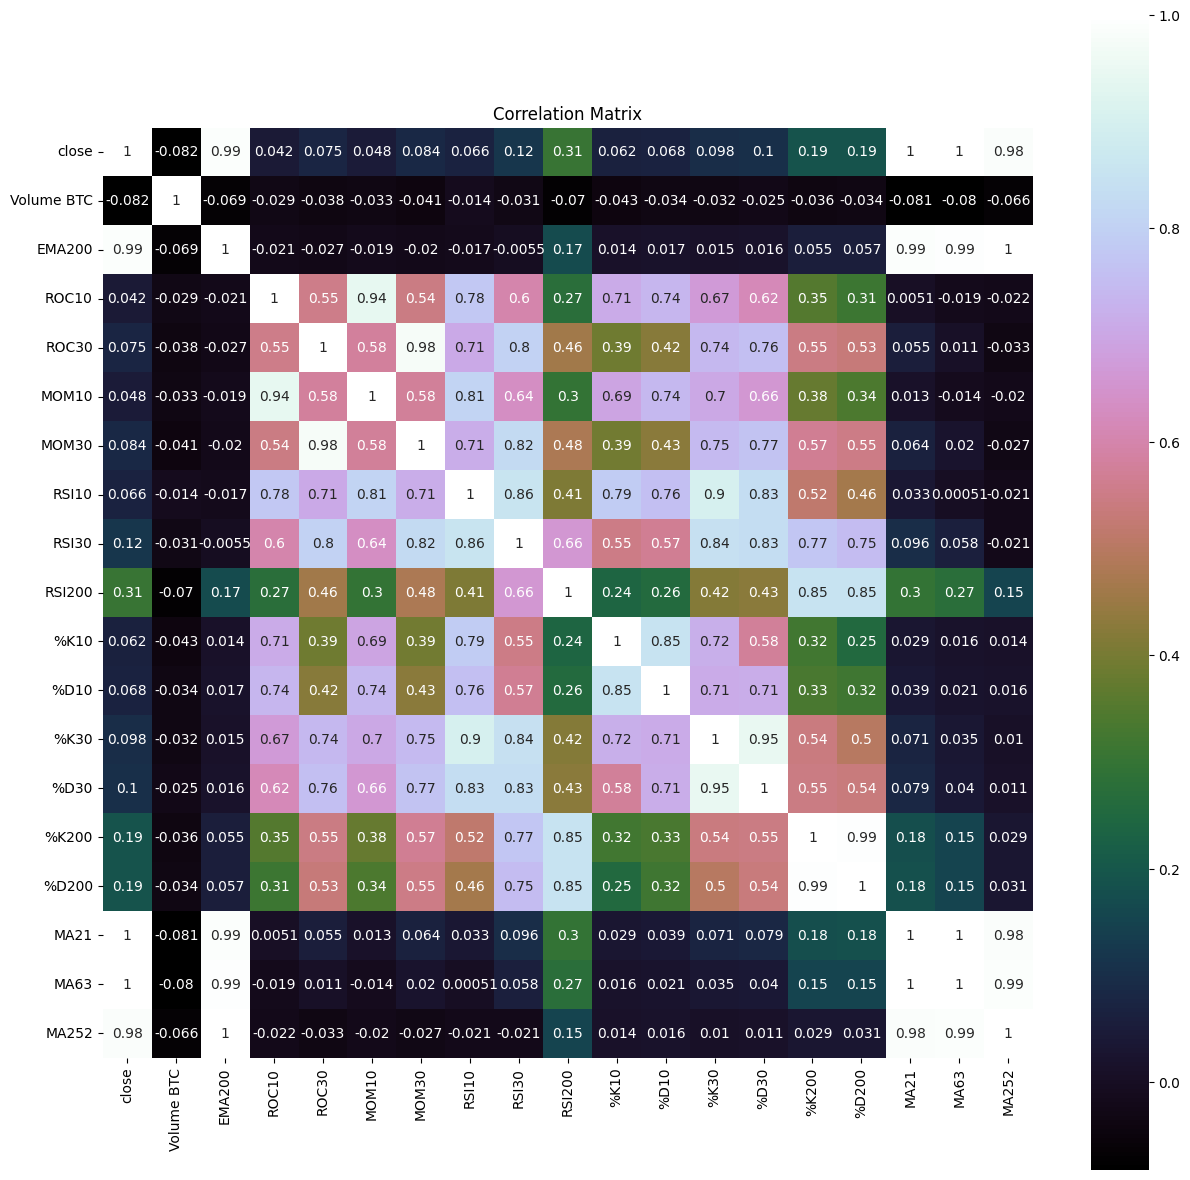

In [ ]:
# correlation
correlation = dataset.drop(['date', 'symbol'], axis=1).corr() # Drop non-numeric columns 'date' and 'symbol'
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')
plt.show()

In [ ]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["%D200"]
X = subset_dataset.loc[:, dataset.columns != '%D200']
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

In [ ]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring = 'precision'
#scoring = 'recall'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

In [ ]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
#Neural Network
models.append(('NN', MLPClassifier()))
#Ensable Models
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier(n_jobs=-1)))

In [ ]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
Y= subset_dataset["%D200"]
X = subset_dataset.loc[:, dataset.columns != 'signal']
# Drop the 'Date' column
X = X.drop('date', axis=1) # Drop the date column
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

In [ ]:
# split out validation dataset for the end
subset_dataset= dataset.iloc[-100000:]
# Convert the '%D200' column to binary classes (assuming it represents percentage change)
threshold = 0 # Set the threshold for classification
subset_dataset["%D200"] = (subset_dataset["%D200"] > threshold).astype(int) # 1 if above threshold, 0 otherwise

Y= subset_dataset["%D200"]
X = subset_dataset.loc[:, dataset.columns != '%D200']
# Drop the 'Date' column
X = X.drop(['date','symbol'], axis=1) # Pass a list of columns to drop
validation_size = 0.2
seed = 1
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=1)

In [ ]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.999874 (0.000252)
LDA: 0.997040 (0.000978)
KNN: 0.999874 (0.000252)
CART: 1.000000 (0.000000)
NB: 0.999874 (0.000252)
NN: 0.998866 (0.002993)
AB: 0.999937 (0.000189)
GBM: 0.999874 (0.000378)
RF: 0.999874 (0.000252)


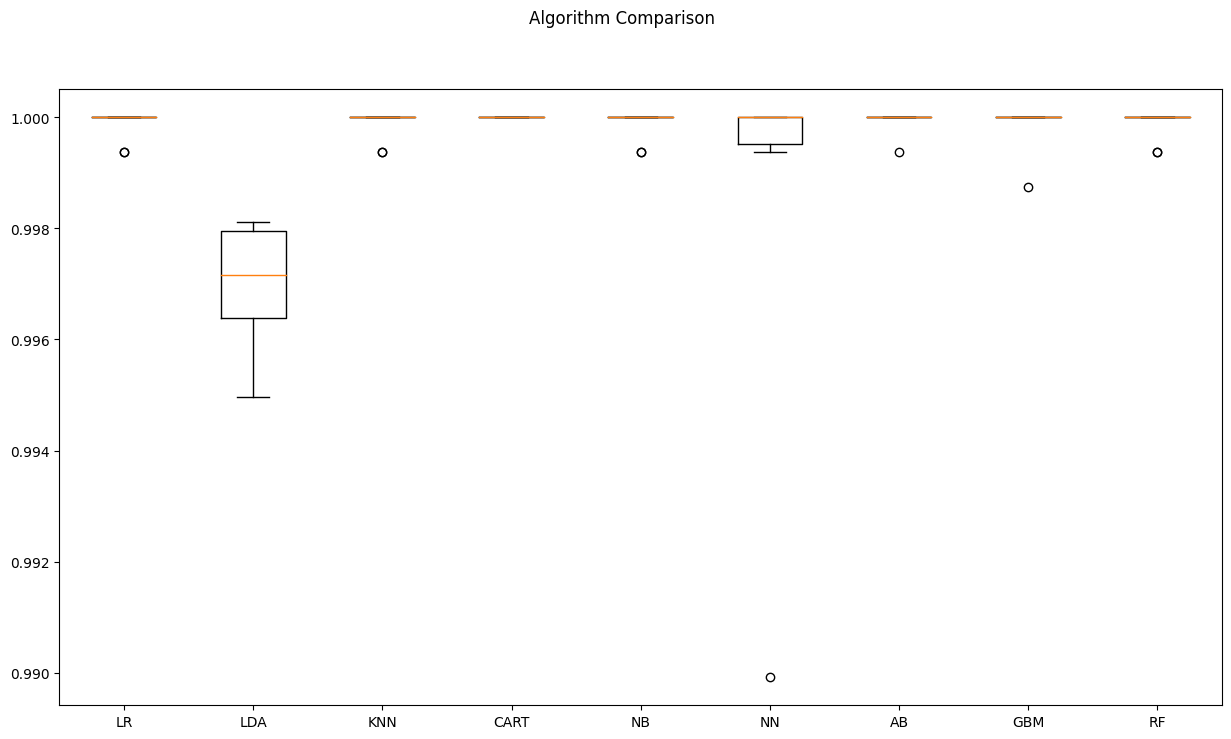

In [ ]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

In [ ]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
n_estimators = [20,80]
max_depth= [5,10]
criterion = ["gini","entropy"]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, criterion = criterion )
model = RandomForestClassifier(n_jobs=-1)
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.999937 using {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#1 0.999937 (0.000189) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 20}
#3 0.999874 (0.000252) with: {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 80}
#1 0.999937 (0.000189) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 20}
#3 0.999874 (0.000252) with: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 80}
#3 0.999874 (0.000252) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 20}
#3 0.999874 (0.000252) with: {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 80}
#3 0.999874 (0.000252) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 20}
#3 0.999874 (0.000252) with: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 80}


In [ ]:
# prepare model
model = RandomForestClassifier(criterion='gini', n_estimators=80,max_depth=10,n_jobs=-1) # rbf is default kernel
#model = LogisticRegression()
model.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, n_jobs=-1)

In [ ]:
# estimate accuracy on validation set
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

1.0
[[3970]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00      3970

    accuracy                           1.00      3970
   macro avg       1.00      1.00      1.00      3970
weighted avg       1.00      1.00      1.00      3970



<Axes: xlabel='Predicted', ylabel='Actual'>

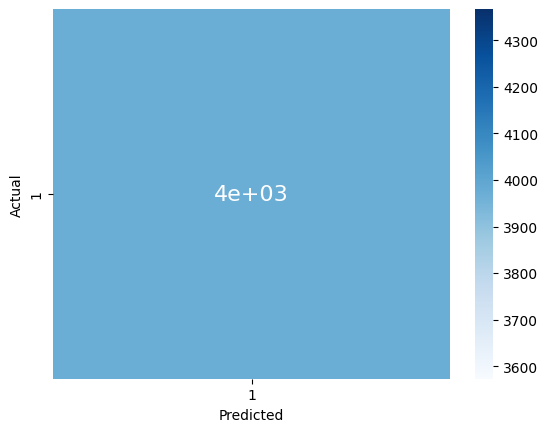

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(Y_validation, predictions), columns=np.unique(Y_validation), index = np.unique(Y_validation))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font sizes

Text(0.5, 0, 'Variable Importance')

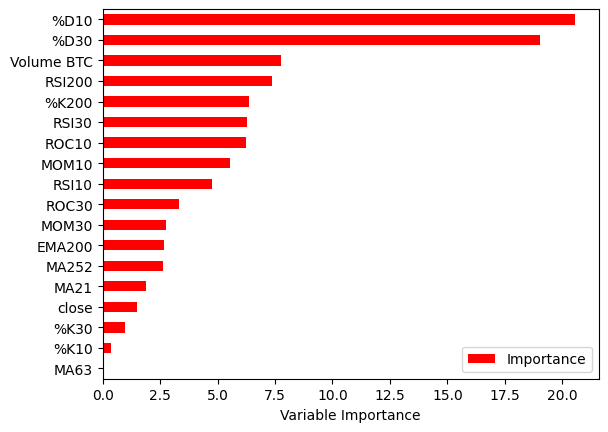

In [ ]:
Importance = pd.DataFrame({'Importance':model.feature_importances_*100}, index=X.columns)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r' )
plt.xlabel('Variable Importance')

<Axes: >

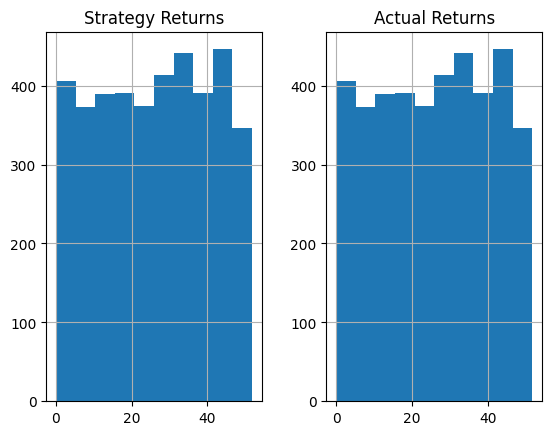

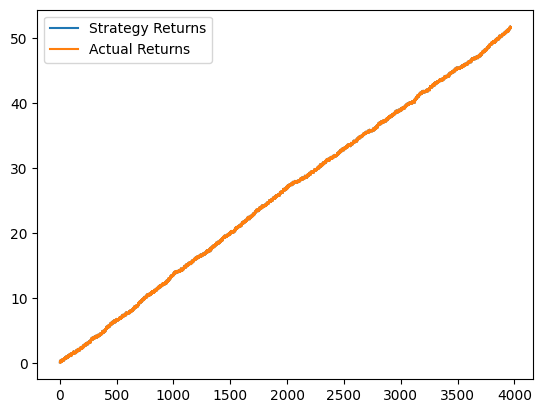

In [ ]:
#Create column for Strategy Returns by multiplying the daily returns by the position that was held at close
#of business the previous day
backtestdata = pd.DataFrame(index=X_validation.index)
#backtestdata = pd.DataFrame()
backtestdata['signal_pred'] = predictions
backtestdata['signal_actual'] = Y_validation
backtestdata['Market Returns'] = X_validation['close'].pct_change()
backtestdata['Actual Returns'] = backtestdata['Market Returns'] * backtestdata['signal_actual'].shift(1)
backtestdata['Strategy Returns'] = backtestdata['Market Returns'] * backtestdata['signal_pred'].shift(1)
backtestdata=backtestdata.reset_index()
backtestdata.head()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().hist()
backtestdata[['Strategy Returns','Actual Returns']].cumsum().plot()

In [ ]:
from google.colab import files
f = files.upload()

# Convert ipynb to html
import subprocess
file0 = list(f.keys())[0]
_ = subprocess.run(["pip", "install", "nbconvert"])
_ = subprocess.run(["jupyter", "nbconvert", file0, "--to", "html"])

# download the html
files.download(file0[:-5]+"html")